**Training the UNET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import numpy as np
import cv2
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.metrics import MeanIoU
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
os.makedirs("files/non_aug", exist_ok=True)

In [ ]:
!unzip /content/drive/MyDrive/unet_land_seg/data.zip

Archive:  /content/drive/MyDrive/unet_land_seg/data.zip
   creating: dataset/
  inflating: dataset/.DS_Store       
   creating: dataset/non_aug/
   creating: dataset/non_aug/train/
   creating: dataset/non_aug/train/images/
  inflating: dataset/non_aug/train/images/HL1.tif_patch_58_17.tif  
  inflating: dataset/non_aug/train/images/HL1.tif_patch_51_27.tif  
  inflating: dataset/non_aug/train/images/HL1.tif_patch_92_50.tif  
  inflating: dataset/non_aug/train/images/HL1.tif_patch_77_37.tif  
  inflating: dataset/non_aug/train/images/HL1.tif_patch_79_32.tif  
  inflating: dataset/non_aug/train/images/HL1.tif_patch_85_60.tif  
  inflating: dataset/non_aug/train/images/HL1.tif_patch_73_84.tif  
  inflating: dataset/non_aug/train/images/HL1.tif_patch_82_41.tif  
  inflating: dataset/non_aug/train/images/HL1.tif_patch_101_49.tif  
  inflating: dataset/non_aug/train/images/HL1.tif_patch_67_26.tif  
  inflating: dataset/non_aug/train/images/HL1.tif_patch_67_32.tif  
  inflating: dataset/non_a

In [ ]:
!ls /content/dataset

non_aug


In [ ]:
# Set the seed values
os.environ["PYTHONHASHSEED"] = str(42)  # Ensures hash-based randomness is fixed
np.random.seed(42)  # NumPy random seed
tf.random.set_seed(42)  # TensorFlow random seed

# Define hyperparameters
batch_size = 8       # Number of images per batch
lr = 1e-4            # Learning rate (0.0001)
epochs = 100         # Total number of training epochs
height = 256         # Input image height
width = 256          # Input image width


In [ ]:
dataset_path = os.path.join("/content/dataset", "non_aug")
files_dir = os.path.join("files", "non_aug")
model_file = os.path.join(files_dir, "unet-non-aug.keras")
log_file = os.path.join(files_dir, "log-non-aug.csv")

train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "val")


In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
# Convolutional Block: Applies two Conv2D layers with Batch Normalization & ReLU activation
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

# Encoder Block: Uses conv_block and downsampling with MaxPooling
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)  # Apply convolution block
    p = MaxPool2D((2, 2))(x)  # Downsample feature map
    return x, p  # Return both feature map & pooled output

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)  # Upsampling
    x = Concatenate()([x, skip])  # Concatenate with skip connection
    x = conv_block(x, num_filters)  # Apply two convolution layers
    return x

In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    """ Bridge """
    b1 = conv_block(p4, 1024)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model


**Dataset pipeline**

In [ ]:
def load_data(path):
    # Load training images and masks
    train_x = sorted(glob(os.path.join(path, "train", "images", "*")))
    train_y = sorted(glob(os.path.join(path, "train", "masks", "*")))

    # Load validation images and masks
    valid_x = sorted(glob(os.path.join(path, "val", "images", "*")))
    valid_y = sorted(glob(os.path.join(path, "val", "masks", "*")))

    return (train_x, train_y), (valid_x, valid_y)


In [ ]:
def read_image(path):
    path = path.decode()  # Decode bytes to string (for TensorFlow datasets)
    x = cv2.imread(path, cv2.IMREAD_COLOR)  # Read image in color mode
    x = x / 255.0  # Normalize pixel values to range [0,1]
    return x

def read_mask(path):
    path = path.decode()  # Decode bytes to string (for TensorFlow dataset pipelines)
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read mask in grayscale mode
    x = x / 255.0  # Normalize pixel values to range [0,1]
    x = np.expand_dims(x, axis=-1)  # Add a channel dimension
    return x

**tf.data pipeline**

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)  # Read and preprocess the image
        y = read_mask(y)   # Read and preprocess the mask
        return x, y

    # Convert Python function into a TensorFlow operation
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])

    # Set explicit shapes for TensorFlow tensors
    x.set_shape([height, width, 3])  # Image shape (H, W, 3 channels)
    y.set_shape([height, width, 1])  # Mask shape (H, W, 1 channel)
    return x, y

def tf_dataset(x, y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))  # Create dataset from file paths
  dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)  # Preprocess images/masks
  dataset = dataset.batch(batch)  # Group data into batches
  dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Optimize data loading
  return dataset

**Loss**

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice coefficient loss function.
    """
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])  # Adjust axis for your data format
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    """
    Dice loss (1 - dice_coef).  Minimizing this is equivalent to maximizing Dice.
    """
    return 1 - dice_coef(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    """
    Combines Binary Cross-Entropy (BCE) loss and Dice loss.
    """
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)  # Use TensorFlow's BCE
    dice = dice_loss(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice  # Adjust weights as needed


## **Training**

In [ ]:
# Load dataset
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)

# Print dataset size
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

# Create training and validation datasets
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

Train: 921 - 921
Valid: 307 - 307


**Check shape of train dataset**

In [ ]:
for x,y in train_dataset:
  print(x.shape, y.shape)


(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 

**Model summary and callback definition**

In [ ]:
input_shape = (height, width, 3)
model = build_unet(input_shape)
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_mean_io_u', factor=0.1, patience=4, mode='max'),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_mean_io_u', patience=10, mode='max', restore_best_weights=True)  # Stop based on IoU
]


**Hyperparameters search**

In [ ]:

class CustomMeanIoU(MeanIoU):
    def __init__(self, num_classes=2, name="mean_iou", dtype=None):
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)

def build_model(hp):
    """Builds a U-Net model with tunable hyperparameters."""

    # Tune number of filters in encoder/decoder
    filters = hp.Int("filters", min_value=32, max_value=128, step=32)

    # Tune learning rate
    learning_rate = hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5])

    # Build U-Net model with selected filters
    model = build_unet(input_shape=(256, 256, 3))

    # Compile model with Adam optimizer and IoU as a metric
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=bce_dice_loss,
        metrics=["accuracy", CustomMeanIoU(num_classes=2)]
    )

    return model

# Use MeanIoU as the objective instead of val_loss
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_loss", direction="max"),  # Optimize for IoU!
    max_epochs=100,  # Start with a large number
    factor=3,
    directory="hyperband_tuning",
    project_name="unet_tuning"
)

# Start tuning, now optimizing for val_mean_io_u
tuner.search(train_dataset, validation_data=valid_dataset, epochs=100)


Trial 1 Complete [00h 03m 59s]
val_loss: 0.9459472298622131

Best val_loss So Far: 0.9459472298622131
Total elapsed time: 00h 03m 59s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
96                |96                |filters
0.001             |0.0001            |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.8510 - loss: 0.3540 - mean_iou: 0.3585

KeyboardInterrupt: 

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

**Model compile and fit (using best HPS)**

In [ ]:
# Rebuild the model with the best hyperparameters
# model = build_model(best_hps)

# # Compile the model
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
#     loss=bce_dice_loss,
#     metrics=["accuracy", MeanIoU(num_classes=2)]
# )

###################################NO-HYPERPARAMS############################################################
best_learning_rate = 1e-4

# Build the U-Net model
model = build_unet(input_shape=(256, 256, 3))

# Compile the model with the best learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
    loss=bce_dice_loss,
    metrics=["accuracy", MeanIoU(num_classes=2)]
)
###################################################################################################################

# Define callbacks
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_mean_io_u', factor=0.1, patience=4, mode='max', verbose=1),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_mean_io_u', patience=15, mode='max', restore_best_weights=True, verbose=1)
]

# Train the model with increased epochs
history = model.fit(
    train_dataset,                  # Replace with your training dataset
    validation_data=valid_dataset,  # Replace with your validation dataset
    epochs=100,                     # Increased number of epochs
    callbacks=callbacks,
    verbose=1                       # Display detailed training logs
)

Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.8350 - loss: 0.3903 - mean_io_u_1: 0.3518
Epoch 1: val_loss improved from inf to 0.79259, saving model to files/non_aug/unet-non-aug.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 164s 866ms/step - accuracy: 0.8353 - loss: 0.3897 - mean_io_u_1: 0.3517 - val_accuracy: 0.6834 - val_loss: 0.7926 - val_mean_io_u_1: 0.3417 - learning_rate: 1.0000e-04
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_mean_io_u` which is not available. Available metrics are: accuracy,loss,mean_io_u_1,val_accuracy,val_loss,val_mean_io_u_1,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_mean_io_u` which is not available. Available metrics are: accuracy,loss,mean_io_u_1,val_accuracy,val_loss,val_mean_io_u_1,learning_rate
  current = self.get_monitor_value(logs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.8979 - loss: 0.2759 - mean_io_u_1: 0.3535
Epoch 2: val_loss did not improve from 0.79259
116/116 ━━━━━━━━━━━━━━━━━━━━ 115s 538ms/step - accuracy: 0.8979 - loss: 0.2759 - mean_io_u_1: 0.3535 - val_accuracy: 0.6842 - val_loss: 0.8164 - val_mean_io_u_1: 0.3417 - learning_rate: 1.0000e-04
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9030 - loss: 0.2594 - mean_io_u_1: 0.3527
Epoch 3: val_loss improved from 0.79259 to 0.38318, saving model to files/non_aug/unet-non-aug.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 67s 582ms/step - accuracy: 0.9029 - loss: 0.2594 - mean_io_u_1: 0.3526 - val_accuracy: 0.8737 - val_loss: 0.3832 - val_mean_io_u_1: 0.3417 - learning_rate: 1.0000e-04
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.9068 - loss: 0.2471 - mean_io_u_1: 0.3518
Epoch 4: val_loss improved from 0.38318 to 0.27502, saving model to files/non_aug/unet-non-aug.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 79s 553m

**Save model and hyperparameters**

In [ ]:
model.save('/content/drive/MyDrive/unet_land_seg/unet_model.keras')  # Saves in Google Drive
tuner_path = "/content/hyperband_tuning"
drive_path = "/content/drive/MyDrive/unet_land_seg/hyperband_tuning"

# Copy the tuner directory to Google Drive
shutil.copytree(tuner_path, drive_path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/hyperband_tuning'

**Model fit**

In [ ]:
# model.fit(
#     train_dataset,
#     validation_data=valid_dataset,
#     epochs=epochs,
#     callbacks=callbacks
# )

**Load model from file**

In [ ]:
# tf.keras.utils.get_custom_objects()["bce_dice_loss"] = bce_dice_loss
# model_path = "files/non_aug/unet-non-aug.keras"
# model = tf.keras.models.load_model(model_path, custom_objects={"bce_dice_loss": bce_dice_loss})

# # Print model summary to verify
# model.summary()

**Plot metrics**

In [ ]:

# log_file = "files/non_aug/log-non-aug.csv"
# history_df = pd.read_csv(log_file)
# print("Available columns:", history_df.columns)

# plt.figure(figsize=(10, 5))
# plt.plot(history_df["loss"], label="Training Accuracy")
# plt.plot(history_df["val_loss"], label="Validation Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.title("Training and Validation Accuracy Over Epochs")
# plt.show()

# plt.figure(figsize=(10, 5))

# # Plot IoU scores
# plt.plot(history_df["mean-iou_score"], label="Training IoU", color="blue")
# plt.plot(history_df["val_iou_score"], label="Validation IoU", color="orange")

# # Labels and title
# plt.xlabel("Epochs")
# plt.ylabel("IoU Score")
# plt.title("Training and Validation IoU Over Epochs")
# plt.legend()
# plt.show()

**Plot prediciton**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


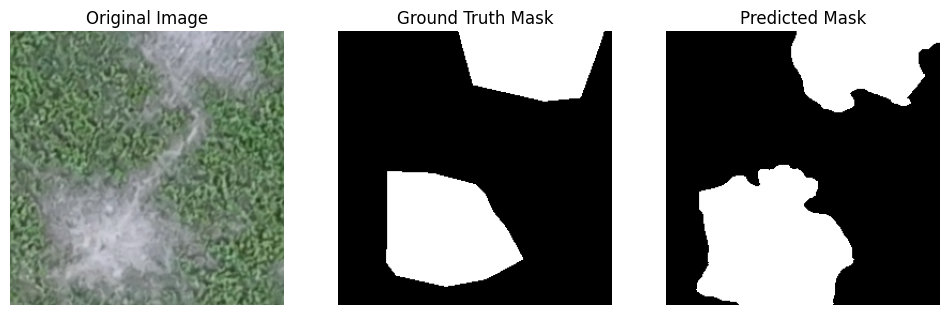

In [ ]:
def read_image_for_plot(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)  # Read image in color mode
    x = x / 255.0  # Normalize pixel values to range [0,1]
    return x

def read_mask_for_plot(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read mask in grayscale mode
    x = x / 255.0  # Normalize pixel values to range [0,1]
    x = np.expand_dims(x, axis=-1)  # Add a channel dimension
    return x

# Load a sample validation image and mask
sample_image_path = valid_x[300]  # First image
sample_mask_path = valid_y[300]  # First mask

sample_image = read_image_for_plot(sample_image_path)
sample_mask = read_mask_for_plot(sample_mask_path)

# Ensure correct shape for model input
input_image = np.expand_dims(sample_image, axis=0)  # Add batch dimension

# Get model prediction
predicted_mask = model.predict(input_image)[0]  # Remove batch dimension

# Threshold the predicted mask (for binary classification)
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

# Plot the original image, ground truth, and predicted mask
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(sample_image)  # Original image
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(sample_mask[..., 0], cmap="gray")  # Ground truth mask
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(predicted_mask[..., 0], cmap="gray")  # Predicted mask
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

plt.show()